In [1]:
# torch and torchvision imports

import torch, torch.nn as nn, torch.optim as optim
from torchmetrics.classification import MultilabelAUROC
import numpy as np,  matplotlib.pyplot as plt, pandas as pd, pickle
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from ResnetModel import *
writer = SummaryWriter()
# from google.colab import drive
# drive.mount('/gdrive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


2023-12-16 14:53:56.061063: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-16 14:53:56.261732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 14:53:56.261812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 14:53:56.287573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 14:53:56.347542: I tensorflow/core/platform/cpu_feature_guar

Device: cuda


### Loading and Preparing Data

In [2]:
X_train = torch.from_numpy(np.transpose(np.load('X_train.npy'), axes = (0,2,1))).float()
X_test = torch.from_numpy(np.transpose(np.load('X_test.npy'), axes = (0,2,1))).float()
y_train = pd.read_pickle('y_train.pickle').to_numpy()
y_test = pd.read_pickle('y_test.pickle').to_numpy()

class_list = []
for classes in y_train:
    class_list += classes 
class_list = set(class_list)
class_list
diagSupclassDict = {val:i for i, val in enumerate(class_list)}
diagSupclassDict['Nodiag'] = 5
print(diagSupclassDict)

train_label_mapping = torch.zeros((X_train.shape[0], len(diagSupclassDict)))
print(f"-"*(1+30+5+35))
for i, classes in enumerate(y_train):
    for diagclass in classes:
        train_label_mapping[i, diagSupclassDict[diagclass]] = 1
    if len(classes) == 0:
        train_label_mapping[i, diagSupclassDict['Nodiag']] = 1
    
    print(f"|  {str(y_train[i]):>30}  |  {str(train_label_mapping[i]):<30}   |")

test_label_mapping = torch.zeros((X_test.shape[0], len(diagSupclassDict)))
print(f"-"*(1+30+5+35))
for i, classes in enumerate(y_test):
    for diagclass in classes:
        test_label_mapping[i, diagSupclassDict[diagclass]] = 1
    if len(classes) == 0:
        test_label_mapping[i, diagSupclassDict['Nodiag']] = 1
    
    print(f"|  {str(y_train[i]):>30}  |  {str(test_label_mapping[i]):<30}   |")

train_dataset = torch.utils.data.TensorDataset(X_train, train_label_mapping)
test_dataset = torch.utils.data.TensorDataset(X_test, test_label_mapping)
x = X_train[0:1]
print(x.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'X_train.npy'

### Creating the Resnet Model

In [3]:
X_train.shape

NameError: name 'X_train' is not defined

In [9]:
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).float()
print(summary(model.to(device), (1,12,1000)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 6]                    --
├─Conv1d: 1-1                            [1, 64, 500]              5,376
├─ReLU: 1-2                              [1, 64, 500]              --
├─BatchNorm1d: 1-3                       [1, 64, 500]              128
├─MaxPool1d: 1-4                         [1, 64, 250]              --
├─Sequential: 1-5                        [1, 256, 250]             --
│    └─Bottleneck: 2-1                   [1, 256, 250]             --
│    │    └─Conv1d: 3-1                  [1, 64, 250]              4,096
│    │    └─ReLU: 3-2                    [1, 64, 250]              --
│    │    └─BatchNorm1d: 3-3             [1, 64, 250]              128
│    │    └─Conv1d: 3-4                  [1, 64, 250]              12,288
│    │    └─ReLU: 3-5                    [1, 64, 250]              --
│    │    └─BatchNorm1d: 3-6             [1, 64, 250]              128
│ 

In [10]:
dir(summary)

['__annotations__',
 '__builtins__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__getstate__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [4]:
(4*1024-107.88)/107.88 #Max batch size

36.96811271783463

In [3]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)

In [4]:
"""Test AUC metric"""
ml_auroc = MultilabelAUROC(num_labels=len(diagSupclassDict), average="macro", thresholds=None)
# ml_auroc(model(X_train[0:10].to(device)), train_label_mapping[0:10].to(device).int())

### Finding Max Learning rate

In [7]:
criterion = nn.BCELoss()
epochs = 10
model = model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).float()
model = model.to(device)
lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

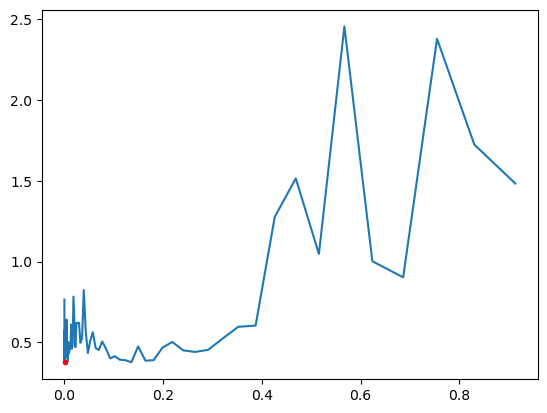

In [8]:
train_loss = []
lrs = []

for i, (signal, labels) in enumerate(train_loader):
    signal = signal.to(device)
    labels = labels.to(device)
    output = model(signal)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    train_loss.append(loss.item())
    lrs.append(lr)
    lr *= 1.1

    for g in optimizer.param_groups:
        g['lr'] = lr 

    optimizer.step()

    if i > 200 or lr > 1:
        break

lrs = np.array(lrs)
train_loss = np.array(train_loss)

lr_max = lrs[np.where(train_loss == train_loss.min())[0]]

fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()


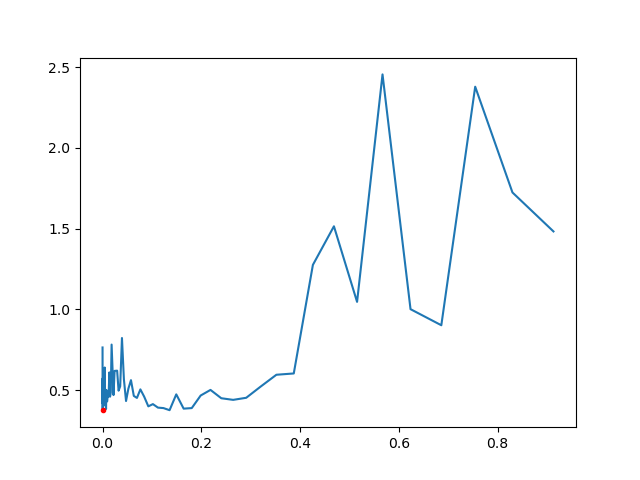

In [9]:
%matplotlib widget
fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()

In [10]:
lr_max

array([0.00025164])

In [11]:
lr_max = 0.135/10
lr = lr_max
epochs = 10
criterion = nn.BCELoss()
epochs = 10
model = model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).float()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

for g in optimizer.param_groups:
    g['lr'] = lr

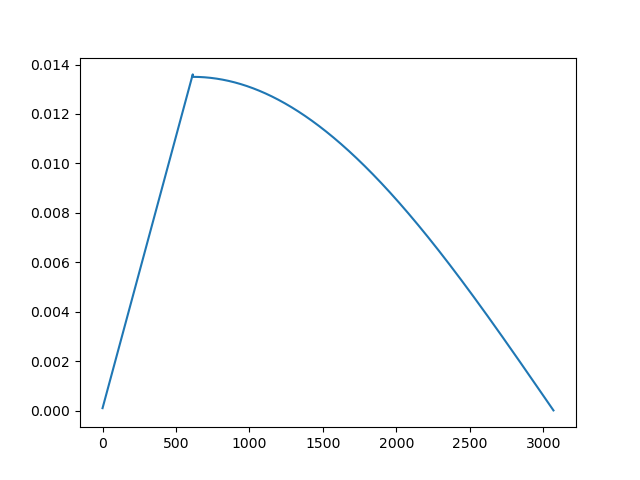

In [12]:
lrs = []
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
for t in range(T_max):
    if t <= T_0:
        lr = 10**(-4) + (t/T_0)*lr_max  
    else: 
        lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6)
    lrs.append(lr)

fig = plt.figure()
plt.plot(lrs)
plt.show()


In [13]:
lr =lr_max

In [14]:
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
learning_rates = []
train_losses = []

for epoch in range(epochs):
    for i, (signal, labels) in enumerate(train_loader):
        signal = signal.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(signal)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        if t <= T_0:
            lr = 10**(-4) + (t/T_0)*lr_max  
        else: 
            lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

        for g in optimizer.param_groups:
            g['lr'] = lr 
        learning_rates.append(lr)
        train_losses.append(loss.item())
        optimizer.step()
        t+=1
        
        train_AUC = ml_auroc(outputs, labels.int())
        writer.add_scalar("Train_Loss", loss, t)
        writer.add_scalar("Learning rate", lr, t)
        writer.add_scalar("Batch Train AUC", train_AUC, t)

        if i%100 == 0:
            print(f"Step: {i+1}/{len(train_loader)}  |  Train loss: {loss.item():.4f}  |  Train AUC: {train_AUC:.4f}")
           

    # model.eval()
    test_auc = 0
    with torch.no_grad():
        for i, (signal, labels) in enumerate(test_loader):
            signal = signal.to(device); labels = labels.to(device)
            outputs = model(signal)
            test_auc += ml_auroc(outputs, labels.int())
        test_auc /= len(test_loader)
    writer.add_scalar("Test AUC", test_auc, epoch)

Step: 1/307  |  Train loss: 0.7426  |  Train AUC: 0.4375


/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 101/307  |  Train loss: 0.3490  |  Train AUC: 0.6821
Step: 201/307  |  Train loss: 0.3765  |  Train AUC: 0.8036
Step: 301/307  |  Train loss: 0.3390  |  Train AUC: 0.7643
Step: 1/307  |  Train loss: 0.2787  |  Train AUC: 0.7503
Step: 101/307  |  Train loss: 0.2880  |  Train AUC: 0.8962
Step: 201/307  |  Train loss: 0.2981  |  Train AUC: 0.8326
Step: 301/307  |  Train loss: 0.3021  |  Train AUC: 0.7357
Step: 1/307  |  Train loss: 0.2306  |  Train AUC: 0.7739
Step: 101/307  |  Train loss: 0.3015  |  Train AUC: 0.8749
Step: 201/307  |  Train loss: 0.3310  |  Train AUC: 0.8297
Step: 301/307  |  Train loss: 0.3045  |  Train AUC: 0.8834
Step: 1/307  |  Train loss: 0.2553  |  Train AUC: 0.7639
Step: 101/307  |  Train loss: 0.3018  |  Train AUC: 0.7441
Step: 201/307  |  Train loss: 0.2716  |  Train AUC: 0.8540
Step: 301/307  |  Train loss: 0.2560  |  Train AUC: 0.7566
Step: 1/307  |  Train loss: 0.3094  |  Train AUC: 0.7384
Step: 101/307  |  Train loss: 0.2630  |  Train AUC: 0.8804
Step:

In [ ]:
model.eval()
test_Auc = 0
with torch.no_grad():
    for i, (signal, labels) in enumerate(test_loader):
        signal = signal.to(device); labels = labels.to(device)
        outputs = model(signal)
        test_Auc += ml_auroc(outputs, labels.int())

test_Auc /= len(test_loader)
test_Auc
        

In [ ]:
import pickle

In [ ]:
with open('resnet101_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len=1000, emb_size=12):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-np.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Transformer):
    def __init__(self, emb_size=12, nhead=6, depth=6, hidden_size=128, seq_length=1000, num_classes=5):
        super(Transformer, self).__init__(d_model=emb_size, nhead=nhead, num_encoder_layers=depth, num_decoder_layers=depth, dim_feedforward=hidden_size)
    
        self.pos_encoder = PositionalEncoding(seq_length, emb_size)
        self.decoder = nn.Linear(emb_size, 256)
        self.linear1 = nn.Linear(256, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, num_classes)
        
    def __forward_impl(self, x):
        #x = self.pos_encoder(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.decoder(x)
        x = torch.relu(x)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        x = torch.sigmoid(x)
        return x
    
    def forward(self, x):
        return self.__forward_impl(x)
    
model = Transformer(nhead=6, hidden_size=512, depth=3).to(device)

model(X_train[0].T.unsqueeze(0))

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[0.4937, 0.5006, 0.4919, 0.5102, 0.4906]], grad_fn=<SigmoidBackward0>)

In [20]:
X_train[0].T.shape

torch.Size([1000, 12])

In [9]:
model = Transformer(nhead=6, hidden_size=512, depth=3).to(device)
print(summary(model, [1000, 12]))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [TransformerEncoder: 1, TransformerEncoderLayer: 3, MultiheadAttention: 4, Dropout: 4, LayerNorm: 4, Linear: 4, Dropout: 4, Linear: 4, Dropout: 4, LayerNorm: 4, TransformerEncoderLayer: 3, MultiheadAttention: 4, Dropout: 4, LayerNorm: 4, Linear: 4, Dropout: 4, Linear: 4, Dropout: 4, LayerNorm: 4, TransformerEncoderLayer: 3, MultiheadAttention: 4, Dropout: 4, LayerNorm: 4, Linear: 4, Dropout: 4, Linear: 4, Dropout: 4, LayerNorm: 4, LayerNorm: 2]

In [11]:
summary(model.to(device), (1,1000, 12))

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [1, 5]                    --
├─TransformerEncoder: 1-1                     [1, 1000, 12]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 1000, 12]             13,484
│    │    └─TransformerEncoderLayer: 3-2      [1, 1000, 12]             13,484
│    │    └─TransformerEncoderLayer: 3-3      [1, 1000, 12]             13,484
│    └─LayerNorm: 2-2                         [1, 1000, 12]             24
├─Linear: 1-2                                 [1, 256]                  3,328
├─Linear: 1-3                                 [1, 512]                  131,584
├─Linear: 1-4                                 [1, 1024]                 525,312
├─Linear: 1-5                                 [1, 5]                    5,125
Total params: 705,825
Trainable params: 705,825
Non-trainable param

In [15]:
512*1024+512

524800

In [ ]:
"""Transformer needs X input as (seq_len, batch_size, channels)"""
model = Transformer(nhead=6, hidden_size=512, depth=3).to(device)
# resnetModel = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).to(device)

# resnetModel(X_train[0:1].to(device))
print("Forward pass")
X_train = X_train.transpose(0,1).transpose(0,2)
model(X_train[:, :17, :].to(device))